## Sickness absence scraper from NHSD published stats
#### Load in data from websites

In [1]:

### Script to scrape published data from NHSD webpages and output a compiled and procesed CSV
### of FTE days available and FTE days lost by staff group and organisation
### Takes up to 10 minutes to run

import pandas as pd
import requests
from datetime import datetime
from bs4 import BeautifulSoup

# Allows unverified SSLs
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# The monthly publication of sickness absences sometimes vary in format (sometimes monthly "provisional", sometimes just monthly, sometimes quarterly)
# These three base URLs pick up on all variations. The code iterates through all possible URL formats for each month (and quarter). Where an invalid
# URL is created, the code will output "Failed to access [URL]", where it is valid it will output "Downloaded and parsed: [URL]". All data about 
# failed/successful access is outputted in a seperate CSV.

base_urls = [
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month}-{year}-provisional-statistics",
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month}-{year}",
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month1}-{year1}-to-{month2}-{year2}-provisional-statistics"
]

accessed_data = []
dfs = []

## Function to get quarterly month values

def get_month_range_quarterly(month):
    quarters = {
        "january": ("january", "march"),
        "april": ("april", "june"),
        "july": ("july", "september"),
        "november": ("november", "december")
    }
    return quarters.get(month, (None, None))

## Iterates over years and months - specify years in range (remember need to +1 to upper range)

for year in range(2018, 2024):
    for month in range(1, 13):
        month_name = datetime(year, month, 1).strftime('%B').lower()

        for base_url in base_urls:
            ## Gets correct year for quarter
            if "{month1}-{year1}-to-{month2}-{year2}" in base_url:
                start_month, end_month = get_month_range_quarterly(month_name)
                if not start_month:
                    continue
                month1 = start_month
                month2 = end_month
                year1 = year
                year2 = year
                if end_month == "december":
                    year2 += 1
                url = base_url.format(month1=month1, year1=year1, month2=month2, year2=year2)
            else:
                url = base_url.format(month=month_name, year=year)

            # Download the monthly webpage
            response = requests.get(url)
            if response.status_code == 200:
                # Parse the HTML content of the monthly webpage
                soup = BeautifulSoup(response.content, "html.parser")
                # Find all the CSV links on the monthly webpage
                csv_links = soup.select('a[href$=".csv"]')

                # Append the accessed webpage to the accessed_data list
                accessed_data.append({"URL": url, "Status": "Accessed", "CSV Count": len(csv_links)})

                # Iterate over the CSV links and download the files
                for link in csv_links:
                    csv_url = link["href"]
                    # Download the CSV file
                    response_csv = requests.get(csv_url)
                    if response_csv.status_code == 200:
                        # Read the CSV data into a DataFrame
                        df = pd.read_csv(csv_url)
                        # Add a new column with the downloaded URL
                        df["Downloaded From"] = csv_url
                        # Append the downloaded data to the dfs list
                        dfs.append(df)
                        # Append the downloaded CSV URL to the downloaded_data list
                        accessed_data.append({"URL": csv_url, "Status": "Downloaded"})
                        print(f"Downloaded and parsed: {csv_url}")
                    else:
                        # Append the failed CSV URL to the downloaded_data list
                        accessed_data.append({"URL": csv_url, "Status": "Failed"})
                        print(f"Failed to download CSV from {csv_url}")
                break  # Exit the loop if CSV files were found and downloaded
            else:
                # Append the failed webpage to the accessed_data list
                accessed_data.append({"URL": url, "Status": "Failed", "CSV Count": 0})
                print(f"Failed to access webpage: {url}")

accessed_df = pd.DataFrame(accessed_data)
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Save the accessed_df to separate CSV file
accessed_df.to_csv("tempdir/accessed_data.csv", index=False)


Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018-to-march-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/february-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/february-2018
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/march-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/s

In [2]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7660846 entries, 0 to 7660845
Data columns (total 50 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Date                           object 
 1   HEE_region_code                object 
 2   HEE_region_name                object 
 3   Org Code                       object 
 4   Org Name                       object 
 5   Org Type                       object 
 6   FTE Days Sick                  float64
 7   FTE Days Available             float64
 8   SA Rate (%)                    float64
 9   Sort_Date                      float64
 10  Downloaded From                object 
 11  Month                          object 
 12  Org code                       object 
 13  Org name                       object 
 14  HEE region code                object 
 15  HEE region name                object 
 16  Cluster group                  object 
 17  Benchmark group                object 
 18  NH

### Process and save sickness absence data

In [156]:
# Filter the 'Downloaded From' for cells containing "benchmarking" because that picks up on
# sickness absence benchmarking data which is in the format we want. 
absence_df = combined_df[combined_df['Downloaded From'].str.contains('benchmarking')].dropna(axis = 1, 
                                                                                             how = 'all').dropna(axis = 0, 
                                                                                             how = 'all').reset_index(drop=True)

In [164]:
# Merge 'Month' and 'DATE' columns into a single column 'Date'
absence_df['Date'] = absence_df['Month'].combine_first(absence_df['DATE'])

# Drop old dates columns
absence_df = absence_df.drop(['Month','DATE'], axis=1)


C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_20236\2699082207.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  absence_df['Date'] = absence_df['Month'].combine_first(absence_df['DATE'])


In [165]:
# Convert the 'Month' column to datetime format
absence_df['Date'] = pd.to_datetime(absence_df['Date'], errors='coerce')

# Convert Month column dates to the format 'YYYY-MM-DD'
absence_df['Date'] = absence_df['Date'].dt.to_period('M').dt.to_timestamp()
sorted(absence_df['Date'].unique())

[Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-

In [166]:
# Do the same thing for all columns containing same data category but different names
columns_to_merge = {
    'NHSE region code': 'NHSE_REGION_CODE',
    'NHSE region name': 'NHSE_REGION_NAME',
    'Org code': 'ORG_CODE',
    'Org name': 'ORG_NAME',
    'FTE days lost': 'FTE_DAYS_LOST',
    'FTE days available': 'FTE_DAYS_AVAILABLE',
    'Sickness absence rate (%)': 'SICKNESS_ABSENCE_RATE_PERCENT',
    'Staff group': 'STAFF_GROUP',
    'Cluster group': 'CLUSTER_GROUP',
    'Benchmark group': 'BENCHMARK_GROUP',
}


In [167]:
# Iterate over the columns to merge
for column, matching_column in columns_to_merge.items():
    # Check if both columns exist in the dataframe
    if column in absence_df.columns and matching_column in absence_df.columns:
        # Merge the columns by filling the missing values
        absence_df[column] = absence_df[column].fillna(absence_df[matching_column])

# Drop the matching columns so only the merged column remains
absence_df = absence_df.drop(columns_to_merge.values(), axis=1)


In [168]:
# clean up and simplify data frame
to_drop = ['Downloaded From','Tm End Date','ICS_CODE','ICS_NAME','HEE region code',
         'HEE region name','Sickness absence rate (%)']
replace_dict_region = {'South East of England':'South East',
                'South West of England':'South West'}
replace_dict_staff = {'All staff':'All staff groups',
                'HCHS Doctors':'HCHS doctors (exc. junior Drs)',
                'HCHS doctors':'HCHS doctors (exc. junior Drs)'}
df = absence_df.sort_values('Date')
df['NHSE region name'] = df['NHSE region name'].replace(replace_dict_region)
df['Staff group'] = df['Staff group'].replace(replace_dict_staff)
df.drop(to_drop,axis=1, inplace=True)
order = ['Date','Org code','Org name','NHSE region code','NHSE region name','Cluster group','Benchmark group',
         'Staff group','FTE days lost','FTE days available']
df = df.drop_duplicates()
df = df[order].reset_index(drop=True)

In [169]:
# remove rows where 'fte days available' is nan as assume no data available
df = df.dropna(subset=['FTE days available'])


In [170]:
df.tail()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,FTE days lost,FTE days available
319836,2023-02-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Managers,32.00000,2932.17352
319837,2023-02-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Midwives,272.31989,7278.63691
319838,2023-02-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Nurses & health visitors,3420.83393,80320.14708
319839,2023-02-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,"Scientific, therapeutic & technical staff",1533.27159,37361.81908
319840,2023-02-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Support to ST&T staff,1240.06227,23361.67261


Data for June 2022 is missing. To fill the missing values I will duplicate May 2022's valid data for June 2022 (2022-06-01).

In [176]:

# Find the data corresponding to 2022-05-01
may_data = df[df['Date'] == pd.to_datetime('2022-05-01')]

# Create a copy of the data with the date changed to 2022-06-01
june_data = may_data.copy()
june_data['Date'] = pd.to_datetime('2022-06-01')

# Append the copied data to the original DataFrame
df2 = pd.concat([df, june_data], ignore_index=True)

df2_check = df2[df2['Date'] == pd.to_datetime('2022-06-01')]
df2_check.head()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,FTE days lost,FTE days available
264774,2022-06-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Midwives,429.43321,7939.85624
264775,2022-06-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Managers,73.00000,4271.13354
264776,2022-06-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,"Hotel, property & estates",685.26659,14123.27137
264777,2022-06-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,Central functions,505.36476,23549.77478
264778,2022-06-01,RDE,East Suffolk and North Essex NHS Foundation Trust,Y61,East of England,Acute,Acute - Large,HCHS doctors (exc. junior Drs),517.61330,33497.65407


In [175]:
df2.to_csv('../sickness_absence.csv', index=False)

### Process and save sickness absence *reason* data

Filter the 'Downloaded From' for cells containing "REASON" because that picks up on sickness absence reason data. Drop other columns that contain all NAs.

In [177]:
reason_df = combined_df[combined_df['Downloaded From'].str.contains('REASON')].dropna(axis = 1, 
                                                                                      how = 'all').dropna(axis = 0, 
                                                                                      how = 'all').reset_index(drop=True)

reason_df = reason_df.drop(['Downloaded From'], axis=1)

In [179]:
reason_df['Month'] = pd.to_datetime(reason_df['Month'])
sorted(reason_df['Month'].unique())

[Timestamp('2015-01-31 00:00:00'),
 Timestamp('2015-02-28 00:00:00'),
 Timestamp('2015-03-31 00:00:00'),
 Timestamp('2015-04-30 00:00:00'),
 Timestamp('2015-05-31 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-08-31 00:00:00'),
 Timestamp('2015-09-30 00:00:00'),
 Timestamp('2015-10-31 00:00:00'),
 Timestamp('2015-11-30 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-02-29 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-30 00:00:00'),
 Timestamp('2016-05-31 00:00:00'),
 Timestamp('2016-06-30 00:00:00'),
 Timestamp('2016-07-31 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-30 00:00:00'),
 Timestamp('2016-10-31 00:00:00'),
 Timestamp('2016-11-30 00:00:00'),
 Timestamp('2016-12-31 00:00:00'),
 Timestamp('2017-01-31 00:00:00'),
 Timestamp('2017-02-28 00:00:00'),
 Timestamp('2017-03-31 00:00:00'),
 Timestamp('2017-04-30 00:00:00'),
 Timestamp('2017-05-

Another approach to see if we can get later data - where REASON column is populated 

In [180]:
reason_df2 = combined_df[combined_df['REASON'].notna()].dropna(axis = 1, how = 'all').dropna(axis = 0, 
                                                                                      how = 'all').reset_index(drop=True)

In [181]:
reason_df2 = reason_df2.drop(['Downloaded From'], axis=1)
reason_df2['DATE'] = pd.to_datetime(reason_df2['DATE'])
sorted(reason_df2['DATE'].unique())

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_20236\2159038178.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  reason_df2['DATE'] = pd.to_datetime(reason_df2['DATE'])


[Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-05-31 00:00:00'),
 Timestamp('2022-07-31 00:00:00'),
 Timestamp('2022-08-31 00:00:00'),
 Timestamp('2022-09-30 00:00:00'),
 Timestamp('2022-10-31 00:00:00'),
 Timestamp('2022-11-30 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-02-28 00:00:00')]

Looks like this is where the rest of the data are so we need to stitch together these dfs. There is someoverlap so I will cut 2022-04 and 2022-05 from the first df. Then process them both in that same way:

In [182]:
reason_df = reason_df[reason_df['Month'] < '2022-04-30']
#sorted(reason_df['Month'].unique())

In [183]:
# Convert Month column dates to the format 'YYYY-MM-DD'
reason_df['Month'] = reason_df['Month'].dt.to_period('M').dt.to_timestamp()


C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_20236\1233521065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reason_df['Month'] = reason_df['Month'].dt.to_period('M').dt.to_timestamp()


In [185]:
reason_df.tail()

,Month,Staff group,Type,Reason,FTE days
813901,2022-03-01,Support to ST&T staff,FTE days lost,S22 Dental and oral problems,685.90562
813902,2022-03-01,Support to ST&T staff,FTE days lost,S28 Injury fracture,6035.33039
813903,2022-03-01,Support to ST&T staff,FTE days lost,S29 Nervous system disorders,1369.26314
813904,2022-03-01,Support to ST&T staff,FTE days lost,S31 Skin disorders,831.91314
813905,2022-03-01,Support to ST&T staff,FTE days lost,S32 Substance abuse,41.70000


In [186]:
# Convert DATE column dates to the format 'YYYY-MM-DD'
reason_df2['DATE'] = reason_df2['DATE'].dt.to_period('M').dt.to_timestamp()


In [187]:
reason_df2.head()

,DATE,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,REASON
0,2022-04-01,2.266051e+06,3.933588e+07,All staff groups,ALL REASONS
1,2022-04-01,4.630816e+05,0.000000e+00,All staff groups,S10 Anxiety/stress/depression/other psychiatri...
2,2022-04-01,8.461698e+04,0.000000e+00,All staff groups,S11 Back Problems
3,2022-04-01,1.614129e+05,0.000000e+00,All staff groups,S12 Other musculoskeletal problems
4,2022-04-01,2.546760e+05,0.000000e+00,All staff groups,S13 Cold Cough Flu - Influenza


In [188]:
reason_df.rename(columns={'Month': 'Date'}, inplace=True)

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_20236\652623737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reason_df.rename(columns={'Month': 'Date'}, inplace=True)


In [190]:
reason_df2.rename(columns={'DATE': 'Date','FTE_DAYS_LOST':'FTE days lost',
                           'STAFF_GROUP':'Staff group','REASON':'Reason'}, inplace=True)

In [191]:
reason_df['Type'].unique()

array(['FTE days available', 'FTE days lost'], dtype=object)

In [192]:
# Pivot the 'Type' column using pivot_table
p_reason_df = pd.pivot_table(reason_df, index=['Date','Reason','Staff group'], columns=['Type'], values='FTE days', aggfunc='sum')

# Reset the index
p_reason_df.reset_index(inplace=True)


FTE days available is only recorded for all reasons (not broken down by sickness absence reason), so we can drop that column


In [193]:
p_reason_df = p_reason_df.drop(['FTE days available'], axis=1)

In [194]:
reason_df2 = reason_df2.drop(['FTE_DAYS_AVAILABLE'], axis=1)

In [195]:
p_reason_df.head()

Type,Date,Reason,Staff group,FTE days lost
0,2015-01-01,All reasons,All staff groups,2.314284e+07
1,2015-01-01,All reasons,Ambulance staff,6.245611e+05
2,2015-01-01,All reasons,Associate Specialist,3.291103e+04
3,2015-01-01,All reasons,Central functions,1.597401e+06
4,2015-01-01,All reasons,Consultant,2.375077e+05


In [196]:
reason_df2.head()

,Date,FTE days lost,Staff group,Reason
0,2022-04-01,2.266051e+06,All staff groups,ALL REASONS
1,2022-04-01,4.630816e+05,All staff groups,S10 Anxiety/stress/depression/other psychiatri...
2,2022-04-01,8.461698e+04,All staff groups,S11 Back Problems
3,2022-04-01,1.614129e+05,All staff groups,S12 Other musculoskeletal problems
4,2022-04-01,2.546760e+05,All staff groups,S13 Cold Cough Flu - Influenza


In [197]:
cat_reason_df = pd.concat([p_reason_df, reason_df2], ignore_index=True)


In [198]:
cat_reason_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63980 entries, 0 to 63979
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           63980 non-null  datetime64[ns]
 1   Reason         63980 non-null  object        
 2   Staff group    63980 non-null  object        
 3   FTE days lost  63980 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.0+ MB


Import sickness absence reference table to decode reason information into a new column

In [199]:
url = 'REF_SICK_ABSENCE_REASONS.csv'
df_ref = pd.read_csv(url)
df_ref.rename(columns={'Sick_Lv1_Reason':'Reason','Sick_Lv1_Description':'Description'},inplace=True) 
df_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sick_Lv1_Code         377 non-null    object
 1   Reason                377 non-null    object
 2   Description           377 non-null    object
 3   Sick_Lv2_Code         377 non-null    object
 4   Sick_Lv2_Reason       377 non-null    object
 5   Sick_Lv2_Description  353 non-null    object
 6   reason_short          377 non-null    object
dtypes: object(7)
memory usage: 20.7+ KB


Add description information to main df

In [200]:
df_reason = pd.merge(cat_reason_df, df_ref[['Reason','reason_short']], on='Reason',how='left')
df_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637781 entries, 0 to 637780
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           637781 non-null  datetime64[ns]
 1   Reason         637781 non-null  object        
 2   Staff group    637781 non-null  object        
 3   FTE days lost  637781 non-null  float64       
 4   reason_short   618925 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 24.3+ MB


In [201]:
# remove rows where 'Description' is nan as this equates to no reason breakdown
df_reason = df_reason.dropna(subset=['reason_short'])

In [202]:
#drop Reason column as information now in reason_short
df_reason = df_reason.drop(['Reason'], axis=1)

In [203]:
# de-duplicate - now lots of duplicate rows
df_reason = df_reason.drop_duplicates()


In [204]:
df_reason.tail()

,Date,Staff group,FTE days lost,reason_short
637713,2023-02-01,Staff Grade,0.30000,headache_mig
637718,2023-02-01,Staff Grade,6.89375,gastro
637749,2023-02-01,Staff Grade,7.00000,infectious_dis
637779,2023-02-01,Staff Grade,35.56000,other
637780,2023-02-01,Staff Grade,11.95000,unknown


There are more staff groups in this data than in the independent variable data - need to compile HCHS doctors and then drop ones that don't match

In [205]:
sorted(df_reason['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Associate Specialist',
 'Central functions',
 'Consultant',
 'Core Training',
 'Foundation Doctor Year 1',
 'Foundation Doctor Year 2',
 'HCHS Doctors',
 'HCHS doctors',
 'Hospital Practitioner / Clinical Assistant',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'NHS infrastructure support',
 'Nurses & health visitors',
 'Other and Local HCHS Doctor Grades',
 'Other staff or those with unknown classification',
 'Professionally qualified clinical staff',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Specialty Doctor',
 'Specialty Registrar',
 'Staff Grade',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to clinical staff',
 'Support to doctors, nurses & midwives']

In [206]:
clinical_grades = ['Specialty Doctor',
 'Specialty Registrar',
 'Staff Grade',
 'Professionally qualified clinical staff',
 'Other and Local HCHS Doctor Grades',
 'Hospital Practitioner / Clinical Assistant',
 'HCHS doctors',
 'Consultant',
 'Core Training',
 'Foundation Doctor Year 1',
 'Foundation Doctor Year 2',
 'Associate Specialist']


In [207]:
df_reason['Staff group'] = df_reason['Staff group'].replace('HCHS doctors','HCHS doctors (exc. junior Drs)')

In [208]:
sg_in_df_reason = df_reason['Staff group'].unique()
sg_in_df_absence = df['Staff group'].unique()

In [209]:
df_reason = df_reason[df_reason['Staff group'].isin(sg_in_df_absence)]


Calculate proportion of sickness absence due each reason

In [210]:
# Calculate the total days lost by staff group, reason and 'date'
df_reason['total_days_lost'] = df_reason.groupby(['Staff group', 'Date'])['FTE days lost'].transform('sum')

# Calculate the percentage of days lost for each 'staff_group', 'reason', and 'date'
df_reason['percentage_days_lost'] = (df_reason['FTE days lost'] / df_reason['total_days_lost']) 


In [211]:
df_reason.tail()

,Date,Staff group,FTE days lost,reason_short,total_days_lost,percentage_days_lost
635530,2023-02-01,"Support to doctors, nurses & midwives",13250.16797,pregnancy_related,444456.78393,0.029812
635546,2023-02-01,"Support to doctors, nurses & midwives",3702.09118,skin_disorders,444456.78393,0.008329
635560,2023-02-01,"Support to doctors, nurses & midwives",201.54648,substance_abus,444456.78393,0.000453
635564,2023-02-01,"Support to doctors, nurses & midwives",35755.34593,other,444456.78393,0.080447
635565,2023-02-01,"Support to doctors, nurses & midwives",13091.53353,unknown,444456.78393,0.029455


I will create a new dataframe where the proportion of sickness absence days due to each reason is a separate column, format suitable for regression

In [214]:
df_reason_as_cols = df_reason.pivot_table(index=['Date','Staff group'], 
                                          columns='reason_short', values='percentage_days_lost', aggfunc='sum')

In [215]:
df_reason_as_cols.reset_index(inplace=True)
df_reason_as_cols.head()

reason_short,Date,Staff group,anxiety_stress,asthma,back_problems,blood_disorder,dental,endocrine,eye,gastro,...,headache_mig,infectious_dis,nervous_system,other,other_msk,pregnancy_related,respiratory,skin_disorders,substance_abus,unknown
0,2015-01-01,All staff groups,0.240650,0.005032,0.081042,0.004611,0.005471,0.005315,0.009732,0.097381,...,0.019970,0.007180,0.009909,0.106754,0.130557,0.032406,0.072614,0.007171,0.000774,0.117233
1,2015-01-01,Ambulance staff,0.202620,0.000315,0.137649,0.002464,0.002704,0.003397,0.011103,0.078871,...,0.011826,0.004563,0.006138,0.048892,0.143986,0.009491,0.065409,0.005396,0.000386,0.244438
2,2015-01-01,Central functions,0.284872,0.004778,0.057931,0.004319,0.007318,0.005010,0.012109,0.105755,...,0.024926,0.007067,0.008558,0.112053,0.087178,0.020707,0.081521,0.005671,0.001851,0.128868
3,2015-01-01,HCHS doctors (exc. junior Drs),0.259820,0.003406,0.044700,0.005855,0.004394,0.003855,0.014988,0.101290,...,0.016285,0.006457,0.006837,0.142692,0.054098,0.033716,0.043481,0.003676,0.001021,0.230765
4,2015-01-01,"Hotel, property & estates",0.195991,0.003222,0.102186,0.006378,0.005601,0.003548,0.009676,0.096661,...,0.014650,0.008583,0.006566,0.118789,0.185406,0.012533,0.086398,0.009939,0.002620,0.095151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343,2023-02-01,"Scientific, therapeutic & technical staff",0.320518,0.003993,0.038329,0.002511,0.005372,0.004256,0.009558,0.102724,...,0.035241,0.083214,0.010819,0.083645,0.086175,0.043578,0.082206,0.006078,0.000571,0.036551
1344,2023-02-01,Senior managers,0.432715,0.003689,0.022840,0.001872,0.003108,0.013105,0.003931,0.077765,...,0.017318,0.038267,0.010858,0.172282,0.042517,0.010109,0.081912,0.001872,NaN,0.021392
1345,2023-02-01,Support to ST&T staff,0.331511,0.003326,0.051737,0.003061,0.006031,0.006119,0.012206,0.106905,...,0.034108,0.069380,0.011873,0.069979,0.111900,0.020813,0.081566,0.007054,0.001116,0.032738
1346,2023-02-01,Support to ambulance staff,0.343009,0.002881,0.073607,0.005261,0.004435,0.003564,0.009860,0.112150,...,0.027255,0.071860,0.011447,0.056964,0.099931,0.016737,0.081429,0.006024,NaN,0.041368


June 2022 data is missing, as in sickness absence data. I will duplicate May 2022 data for June 2022. 

In [217]:
# Find the data corresponding to 2022-05-01
may_data = df_reason_as_cols[df_reason_as_cols['Date'] == pd.to_datetime('2022-05-01')]

# Create a copy of the data with the date changed to 2022-06-01
june_data = may_data.copy()
june_data['Date'] = pd.to_datetime('2022-06-01')

# Append the copied data to the original DataFrame
df_reason_as_cols2 = pd.concat([df_reason_as_cols, june_data], ignore_index=True)

check = df_reason_as_cols2[df_reason_as_cols2['Date'] == pd.to_datetime('2022-06-01')]
check.head()

reason_short,Date,Staff group,anxiety_stress,asthma,back_problems,blood_disorder,dental,endocrine,eye,gastro,...,headache_mig,infectious_dis,nervous_system,other,other_msk,pregnancy_related,respiratory,skin_disorders,substance_abus,unknown
1348,2022-06-01,All staff groups,0.306557,0.003139,0.056780,0.004677,0.005619,0.005305,0.010589,0.095418,...,0.029573,0.084728,0.011629,0.076982,0.110114,0.035310,0.079240,0.007752,0.000358,0.036922
1349,2022-06-01,Ambulance staff,0.336200,0.002129,0.083383,0.002310,0.003515,0.004387,0.006237,0.089636,...,0.021150,0.101491,0.007134,0.069671,0.105726,0.011334,0.083876,0.004141,NaN,0.044613
1350,2022-06-01,Central functions,0.389315,0.002172,0.041847,0.003773,0.005559,0.005037,0.011632,0.090037,...,0.035317,0.064017,0.008204,0.087163,0.069674,0.021394,0.080235,0.006515,0.001142,0.040663
1351,2022-06-01,"Hotel, property & estates",0.249266,0.003076,0.085656,0.006642,0.005736,0.004092,0.012078,0.098763,...,0.017484,0.068146,0.012586,0.070128,0.182712,0.010209,0.086837,0.009153,0.000711,0.050278
1352,2022-06-01,Managers,0.407476,0.005058,0.026036,0.007871,0.002593,0.002207,0.009604,0.079583,...,0.021990,0.074176,0.006025,0.103755,0.053367,0.010840,0.077978,0.000429,NaN,0.087024


In [218]:
df_reason_as_cols2.to_csv('../sickness_absence_reason_pivot.csv', index=False)

In [219]:
sorted(df_reason['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [220]:
staff_group = 'All staff groups'
df_reason_sg = df_reason.loc[df_reason['Staff group'] == staff_group]

In [230]:
df_reason_sg = df_reason_sg.sort_values(by='percentage_days_lost', ascending=True)

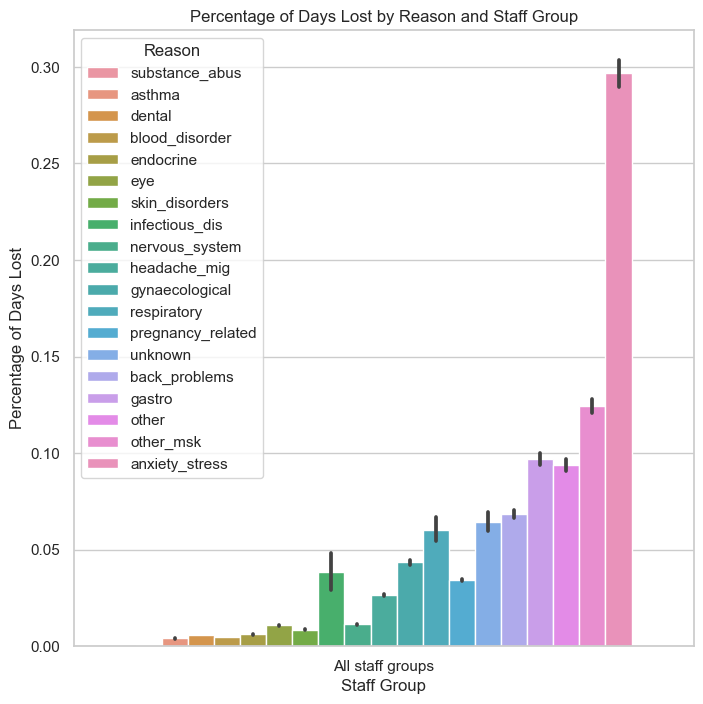

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
sns.barplot(x='Staff group', y='percentage_days_lost', hue='reason_short', data=df_reason_sg)
plt.title('Percentage of Days Lost by Reason and Staff Group')
plt.xlabel('Staff Group')
plt.ylabel('Percentage of Days Lost')
plt.legend(title='Reason')
plt.show()

In [49]:
#df_reason['Description']
# Group the data by 'reason' and calculate the total days lost for each reason
#reasons_totals = df_reason.groupby('Description')['FTE days lost'].sum().reset_index()

# Sort the DataFrame by 'days_lost' in descending order
#reasons_totals = reasons_totals.sort_values(by='FTE days lost', ascending=False)

#reasons_totals

In [223]:
df_reason.to_csv('../sickness_absence_reason.csv', index=False)


### Process and save sickness absence due to COVID data

Filter the 'Downloaded From' for cells containing "COVID-19" because that picks up on sickness absence reason data. 

In [224]:
covid19_df = combined_df[combined_df['Downloaded From'].str.contains('COVID-19')].dropna(axis = 1,
                                                                                          how = 'all').dropna(axis = 0,
                                                                                          how = 'all').reset_index(drop=True)

In [225]:
covid19_df = covid19_df.drop(['Downloaded From'], axis=1)

In [226]:
covid19_df = covid19_df.dropna(subset=['FTE_DAYS_AVAILABLE'])


In [227]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56297 entries, 0 to 69879
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 56297 non-null  object 
 1   NHSE_REGION_CODE     56297 non-null  object 
 2   NHSE_REGION_NAME     56297 non-null  object 
 3   ORG_CODE             56297 non-null  object 
 4   ORG_NAME             56297 non-null  object 
 5   FTE_DAYS_LOST        56036 non-null  float64
 6   FTE_DAYS_AVAILABLE   56297 non-null  float64
 7   STAFF_GROUP          56297 non-null  object 
 8   FTE_DAYS_LOST_COVID  54893 non-null  float64
 9   ICS_CODE             41433 non-null  object 
 10  ICS_NAME             41433 non-null  object 
dtypes: float64(3), object(8)
memory usage: 5.2+ MB


In [228]:
covid19_df.head()

,DATE,NHSE_REGION_CODE,NHSE_REGION_NAME,ORG_CODE,ORG_NAME,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,FTE_DAYS_LOST_COVID,ICS_CODE,ICS_NAME
0,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,2.266051e+06,3.933588e+07,All staff groups,553048.14328,NaN,NaN
1,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,3.186103e+05,7.200150e+06,NHS infrastructure support,61892.77509,NaN,NaN
2,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,1.596052e+03,7.571534e+04,Other staff or those with unknown classification,552.36000,NaN,NaN
3,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,1.049366e+06,2.032216e+07,Professionally qualified clinical staff,294080.27771,NaN,NaN
4,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,8.964790e+05,1.173785e+07,Support to clinical staff,196522.73048,NaN,NaN


In [229]:
covid19_df['DATE'].unique()

TypeError: can't multiply sequence by non-int of type 'method'

In [56]:
covid19_df.to_csv('../covid-19_sickness_absence.csv', index=False)


In [57]:
# import pickle
# with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([absence_df, combined_df, covid19_df, df, df_reason, df_ref,p_reason_df,
#                  reason_df], f)

In [58]:
#with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#    absence_df, combined_df, covid19_df, df, df_reason, df_ref,p_reason_df,reason_df = pickle.load(f)